<a href="https://colab.research.google.com/github/Mariannly/Quark5-CoAfina2025/blob/main/leer_datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisís Historico de Sequías en Riohacha, Colombia



## Descarga de la data

In [1]:
# Instalar modulos necesarios
!pip install -q "cdsapi>=0.7.7" #API ERA5
!pip install -q xarray
!pip install -q cfgrib
!pip install -q --upgrade "xclim>=0.46" #Modulo de estadisticas climáticas

In [15]:
# Importar modulos necesarios
import os
import cdsapi
import time
import xarray as xr
import cfgrib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import xclim as xc

In [3]:
# Acceder a ERA5 con la API
cdsapirc_content = """url: https://cds.climate.copernicus.eu/api
key: 01876cbb-e8a2-4cb4-8d98-5f4ba769fc1a
"""

# Crear el archivo de configuración en la ruta esperada
with open(os.path.expanduser("~/.cdsapirc"), "w") as f:
    f.write(cdsapirc_content)
print("Archivo .cdsapirc creado correctamente")


Archivo .cdsapirc creado correctamente


In [4]:
c = cdsapi.Client()
print("Conexión establecida con Copernicus CDS API")

Conexión establecida con Copernicus CDS API


In [5]:
dataset = "reanalysis-era5-land-monthly-means"
bbox_riohacha = {
    "north": 11.80,
    "south": 11.30,
    "west": -73.20,
    "east": -72.60,
}
request = {
    "product_type": "monthly_averaged_reanalysis",
    "variable": [
        "total_precipitation",
        "2m_temperature",
        "volumetric_soil_water_layer_1",
        "volumetric_soil_water_layer_2",
        "volumetric_soil_water_layer_3",
        "volumetric_soil_water_layer_4",
        "surface_solar_radiation_downwards",
        "evaporation_from_vegetation_transpiration",
        "evaporation_from_bare_soil",
        "potential_evaporation",
        "total_evaporation"
    ],
    "year": [str(y) for y in range(1985, 2025)],   # 1985–2024
    "month": [f"{m:02d}" for m in range(1, 13)],
    "time": "00:00",
    "area": [
        bbox_riohacha["north"],
        bbox_riohacha["west"],
        bbox_riohacha["south"],
        bbox_riohacha["east"],
    ],
    "format": "netcdf",
}

c.retrieve(dataset, request).download()

2025-11-08 16:52:31,503 INFO Request ID is bef80d48-f78c-49d0-84c8-3693cc8dee2d
INFO:ecmwf.datastores.legacy_client:Request ID is bef80d48-f78c-49d0-84c8-3693cc8dee2d
2025-11-08 16:52:31,650 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-11-08 16:52:40,381 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-11-08 17:04:54,193 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


4348f60d6c1baa5921481e4ac392622e.zip:   0%|          | 0.00/417k [00:00<?, ?B/s]

'4348f60d6c1baa5921481e4ac392622e.zip'

In [9]:
data_file = '4348f60d6c1baa5921481e4ac392622e.zip'
#umcompress file
!unzip -q {data_file}

replace data_stream-moda.nc? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [10]:
file = "data_stream-moda.nc"

# Open the NetCDF file using xarray
ds = xr.open_dataset(file)

# Display the dataset information
print(ds)

<xarray.Dataset> Size: 737kB
Dimensions:     (valid_time: 480, latitude: 6, longitude: 7)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 4kB 1985-01-01 ... 2024-12-01
  * latitude    (latitude) float64 48B 11.8 11.7 11.6 11.5 11.4 11.3
  * longitude   (longitude) float64 56B -73.2 -73.1 -73.0 ... -72.8 -72.7 -72.6
    number      int64 8B ...
    expver      (valid_time) <U4 8kB ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 81kB ...
    t2m         (valid_time, latitude, longitude) float32 81kB ...
    swvl1       (valid_time, latitude, longitude) float32 81kB ...
    swvl2       (valid_time, latitude, longitude) float32 81kB ...
    swvl3       (valid_time, latitude, longitude) float32 81kB ...
    swvl4       (valid_time, latitude, longitude) float32 81kB ...
    ssrd        (valid_time, latitude, longitude) float32 81kB ...
    pev         (valid_time, latitude, longitude) float32 81kB ...
    e           (valid_time, latitude, longitude) fl

## Preprocesamiento de datos

In [11]:
# Convertir Data, eliminar valores inncesarios
df = ds.to_dataframe()
df = df.dropna()
df.drop(["number", "expver"], axis=1, inplace=True)
df = df.reset_index()


# Asegura tipo fecha
df["valid_time"] = pd.to_datetime(df["valid_time"])

# Columnas de valor y promdeio mensual
value_cols = ["t2m","swvl1","swvl2","swvl3","swvl4","ssrd","pev","e","tp"]

df = (
    df.groupby("valid_time", as_index=False)[value_cols]
      .mean()
)

In [16]:
# Fechas
t = pd.to_datetime(df["valid_time"]).values

# conviertir a mm/día y ajustar valores
pr_rate  = df["tp"].to_numpy() *30 * 1000.0
pet_rate = -df["pev"].to_numpy() *30 * 1000.0

# Empaquetar con unidades
pr  = xr.DataArray(pr_rate,  coords={"time": t}, dims=("time",), attrs={"units": "mm d-1"})
pet = xr.DataArray(pet_rate, coords={"time": t}, dims=("time",), attrs={"units": "mm d-1"})

# Restar y reasignar units
wb = pr - pet
wb = wb.assign_attrs(units="mm d-1")

# Funciones de SPI y SPEI
SPI  = getattr(xc.indices, "spi",  getattr(xc.indices, "standardized_precipitation_index"))
SPEI = getattr(xc.indices, "spei", getattr(xc.indices, "standardized_precipitation_evapotranspiration_index"))

# Calcular y guardar data
windows = [1, 3, 6, 12]
spi  = {k: SPI(pr, window=k).to_series().rename(f"SPI_{k}") for k in windows}
spei = {k: SPEI(wb=wb, window=k).to_series().rename(f"SPEI_{k}") for k in windows}

In [17]:
# Unir valores de SPI y SPEI
spi_df  = pd.concat(spi.values(), axis=1)
spei_df = pd.concat(spei.values(), axis=1)
indices_df = pd.concat([spi_df, spei_df], axis=1)

# Merge con la df original por fecha
df = df.set_index("valid_time").join(indices_df)
df = df.reset_index()

In [20]:
#days = t.to_numpy()

days = 30

df["e"]  = -df["e"].to_numpy()  *days * 1000.0
df["pev"] = -df["pev"].to_numpy() *days * 1000.0
df["tp"]  = df["tp"].to_numpy() * days * 1000.0

## Visualizaciones

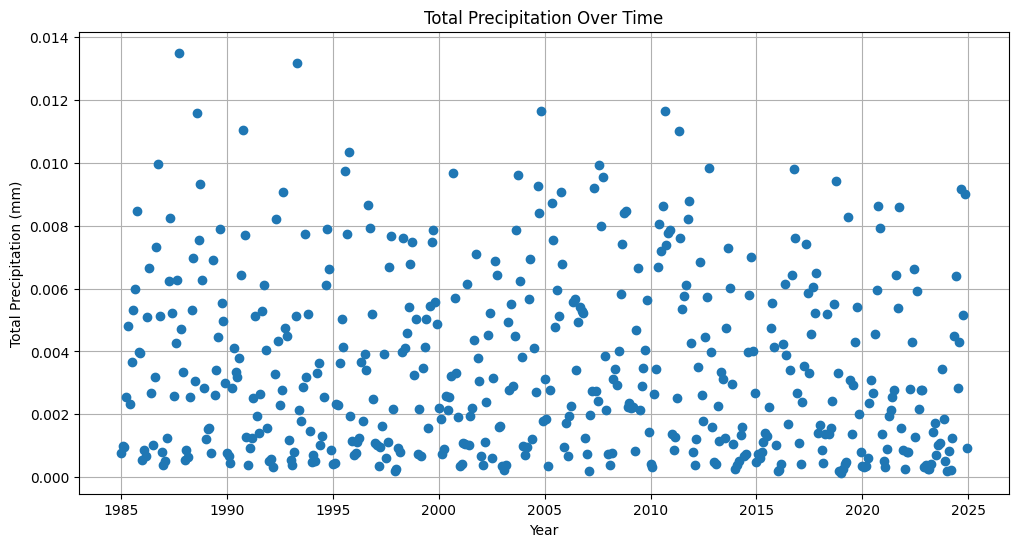

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(df["valid_time"], df['tp'], marker='o', linestyle='')
plt.title('Total Precipitation Over Time')
plt.xlabel('Year')
plt.ylabel('Total Precipitation (mm)')
plt.grid(True)
plt.show()

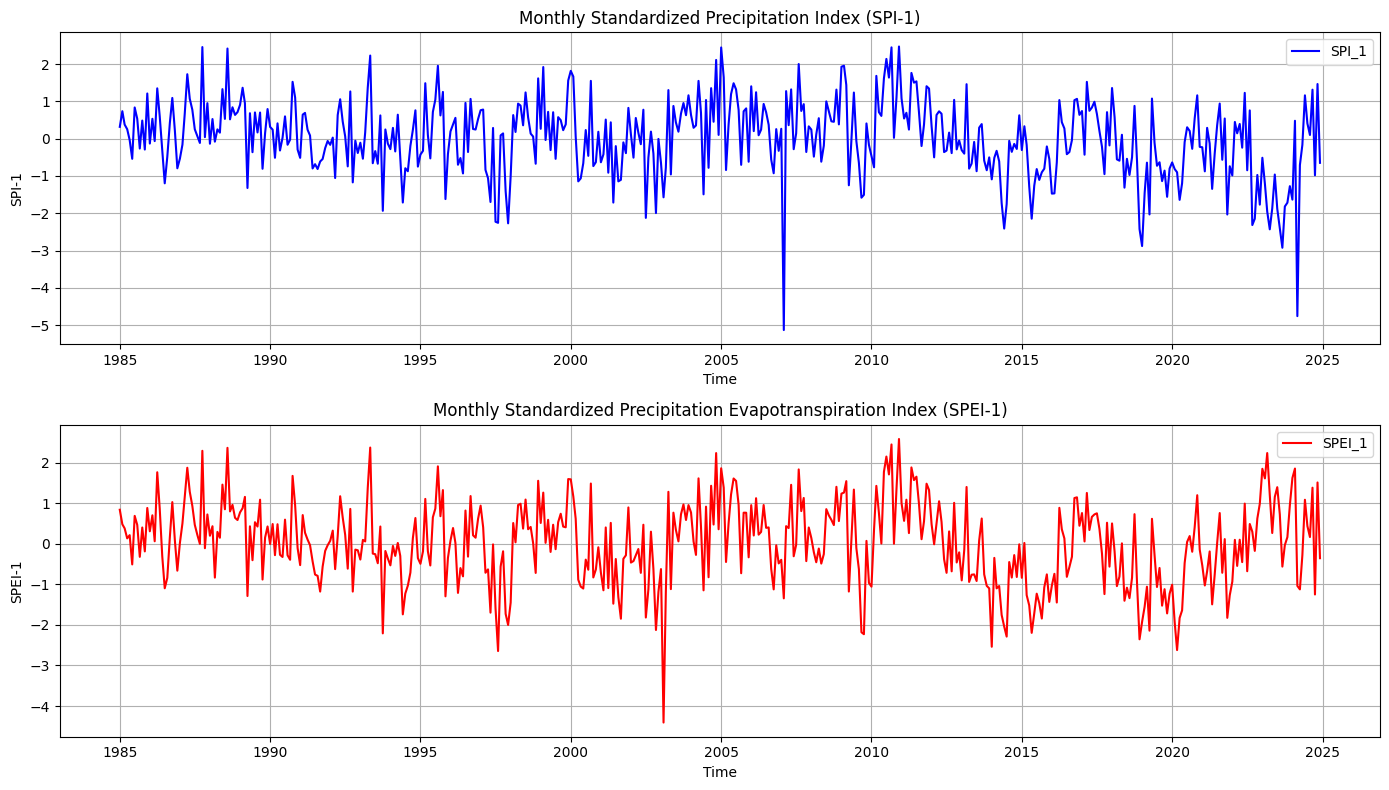

In [21]:
plt.figure(figsize=(14, 8))

# Plot SPI_1
plt.subplot(2, 1, 1) # 2 rows, 1 column, first plot
plt.plot(df["valid_time"], df["SPI_1"], label="SPI_1", color='blue')
plt.title('Monthly Standardized Precipitation Index (SPI-1)')
plt.xlabel('Time')
plt.ylabel('SPI-1')
plt.grid(True)
plt.legend()

# Plot SPEI_1
plt.subplot(2, 1, 2) # 2 rows, 1 column, second plot
plt.plot(df["valid_time"], df["SPEI_1"], label="SPEI_1", color='red')
plt.title('Monthly Standardized Precipitation Evapotranspiration Index (SPEI-1)')
plt.xlabel('Time')
plt.ylabel('SPEI-1')
plt.grid(True)
plt.legend()

plt.tight_layout() # Adjusts subplot params for a tight layout
plt.show()

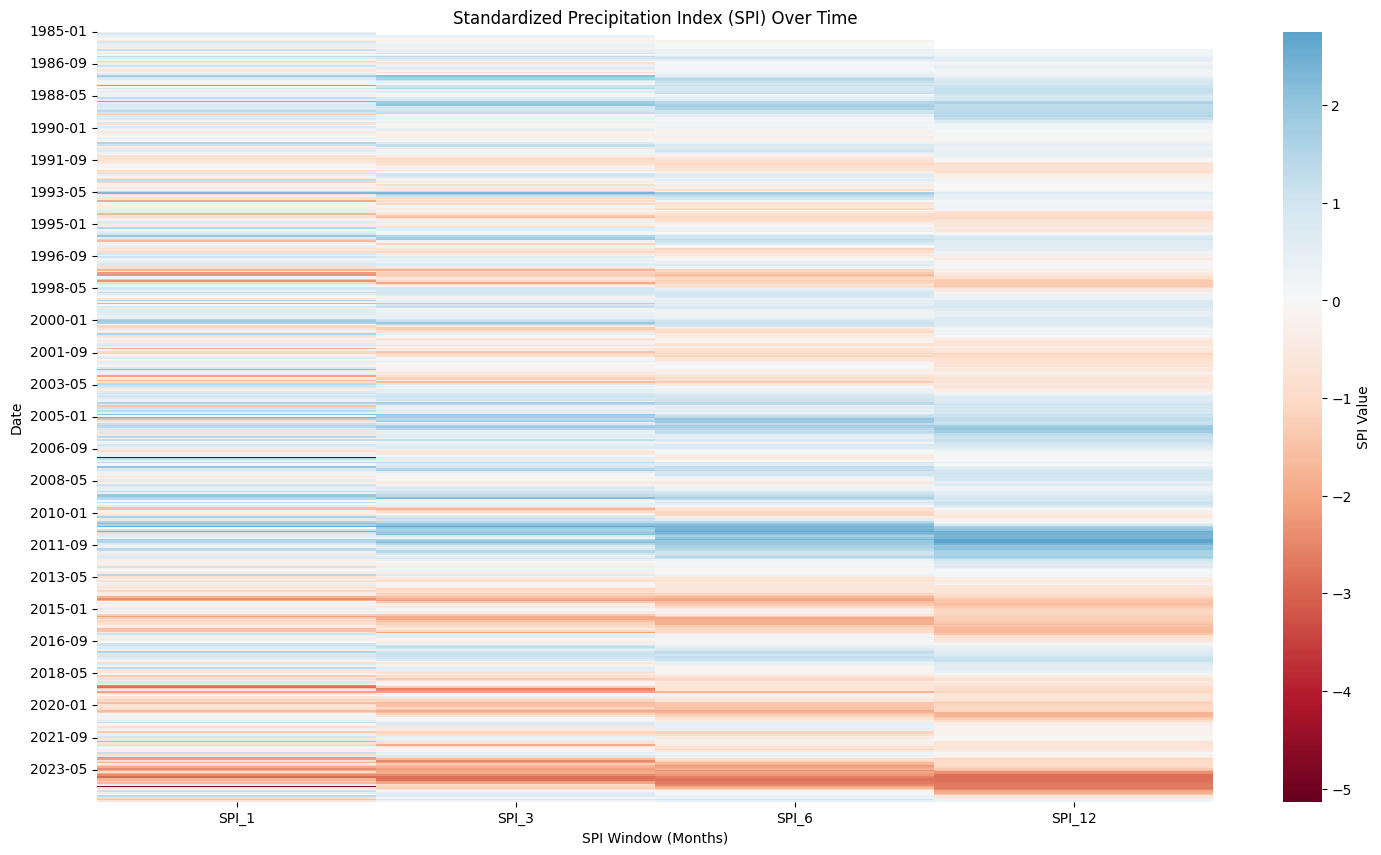

In [26]:
plt.figure(figsize=(18, 10)) # Adjust figure size for better readability
spi_heatmap_data = indices_df[['SPI_1', 'SPI_3', 'SPI_6', 'SPI_12']].dropna(how='all')

sns.heatmap(spi_heatmap_data, cmap='RdBu', center=0, cbar_kws={'label': 'SPI Value'})

# To avoid overly dense Y-axis labels, sample them
n_labels = 20 # Show labels for every 20th month
plt.yticks(np.arange(0, len(spi_heatmap_data), n_labels), spi_heatmap_data.index[::n_labels].strftime('%Y-%m'))
plt.title('Standardized Precipitation Index (SPI) Over Time')
plt.ylabel('Date')
plt.xlabel('SPI Window (Months)')
plt.show()

### Subtask: Calculate Mann-Kendall Trend and Plot

## Summary:

### Data Analysis Key Findings
*   The `pymannkendall` library was successfully installed, which is a prerequisite for performing Mann-Kendall trend analysis.

### Insights or Next Steps
*   Proceed with extracting the `SPEI_12` data and applying the Mann-Kendall trend analysis as outlined in the task.

## Install pymannkendall

### Subtask:
Install the `pymannkendall` library, which provides functions for Mann-Kendall trend analysis.


**Reasoning**:
The user wants to install the `pymannkendall` library. I will use pip with the quiet flag to install it.



In [28]:
!pip install -q pymannkendall

# Task
Install `pymannkendall` and then calculate the Mann-Kendall trend for the `SPEI_12` data, plotting the original series with the Sen's slope trend line and including the Mann-Kendall p-value in the plot title.

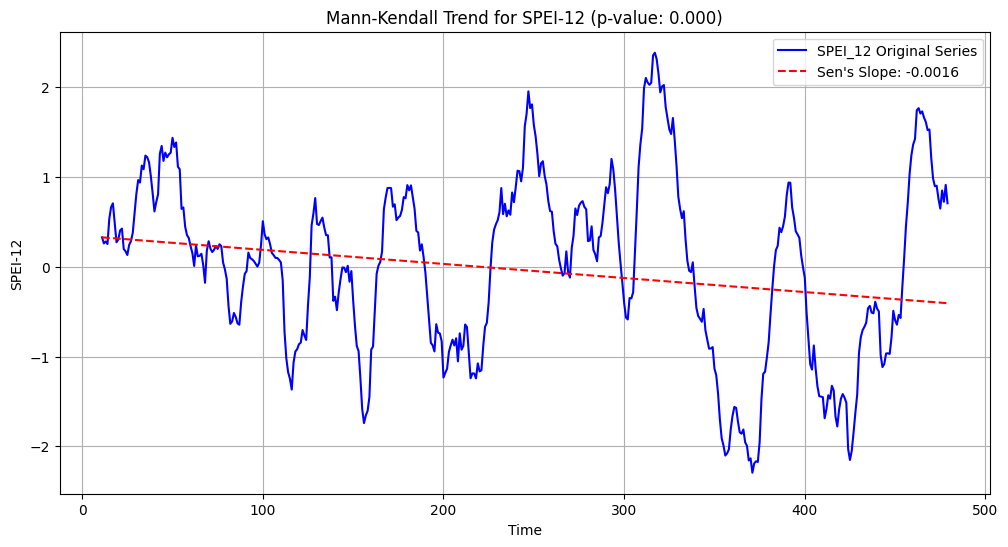

In [29]:
import pymannkendall as mk

# Extract SPEI_12 data and drop NaN values
spei_12_data = df['SPEI_12'].dropna()

# Perform Mann-Kendall test
mk_test_result = mk.original_test(spei_12_data)

# Plot the SPEI_12 series
plt.figure(figsize=(12, 6))
plt.plot(spei_12_data.index, spei_12_data, label='SPEI_12 Original Series', color='blue')

# Calculate Sen's slope trend line
# The Sen's slope is already available in the mk_test_result
slope = mk_test_result.slope
intercept = spei_12_data.iloc[0] - slope * (spei_12_data.index[0] - spei_12_data.index[0])

# Generate trend line points
trend_line = slope * (spei_12_data.index - spei_12_data.index[0]) + spei_12_data.iloc[0]

plt.plot(spei_12_data.index, trend_line, color='red', linestyle='--', label=f"Sen's Slope: {slope:.4f}")

plt.title(f'Mann-Kendall Trend for SPEI-12 (p-value: {mk_test_result.p:.3f})')
plt.xlabel('Time')
plt.ylabel('SPEI-12')
plt.grid(True)
plt.legend()
plt.show()

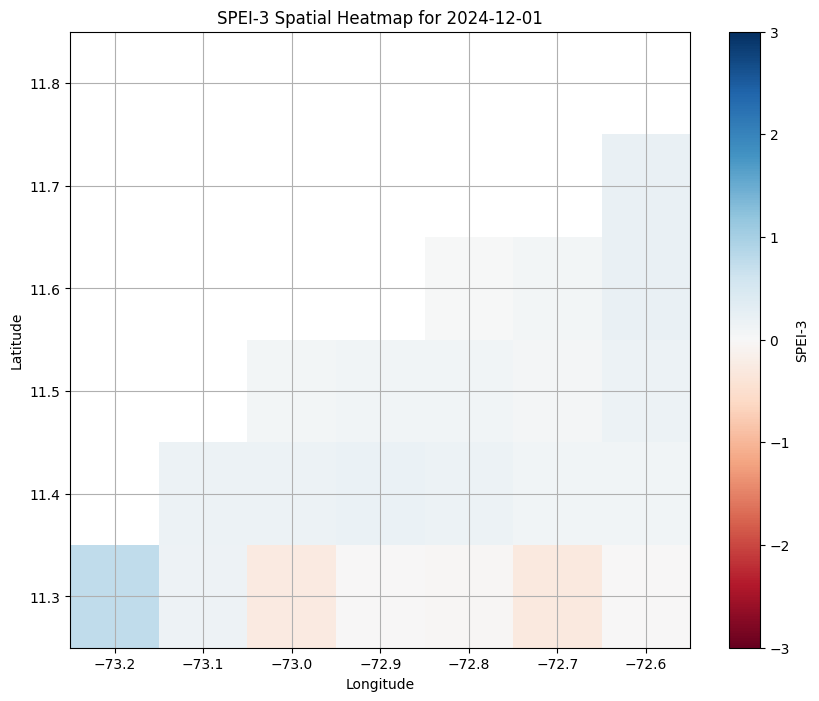

In [25]:
# Extract precipitation and potential evaporation as xarray DataArrays
# ds['tp'] is total_precipitation in meters per month, ds['pev'] is potential_evaporation in meters per month
# Convert from meters to millimeters
pr = ds['tp'] * 1000.0  # now in mm/month (amount)
pet = -ds['pev'] * 1000.0 # now in mm/month (amount)

# Calculate the number of days in each month
days_in_month = ds['valid_time'].dt.days_in_month

# Convert monthly accumulated mm to daily average mm/day
pr_daily_rate = pr / days_in_month
pet_daily_rate = pet / days_in_month

# Assign units for xclim to properly handle calculations
pr_daily_rate = pr_daily_rate.assign_attrs(units="mm/day")
pet_daily_rate = pet_daily_rate.assign_attrs(units="mm/day")

# Calculate Water Balance (Precipitation - Potential Evaporation) preserving spatial dimensions
wb_spatial = pr_daily_rate - pet_daily_rate
wb_spatial = wb_spatial.assign_attrs(units="mm/day")

# Rename 'valid_time' to 'time' for xclim compatibility
wb_spatial = wb_spatial.rename({'valid_time': 'time'})

# Calculate SPEI with a 3-month window, preserving spatial dimensions
# Using the SPEI function defined earlier
SPEI_spatial = SPEI(wb=wb_spatial, window=3)

# Select the last available time for the heatmap
last_time = SPEI_spatial['time'].isel(time=-1)

# Select the SPEI data for this specific time step
spei_last_month = SPEI_spatial.sel(time=last_time, method='nearest')

# Plot the spatial heatmap
plt.figure(figsize=(10, 8))
spei_last_month.plot(
    x='longitude',
    y='latitude',
    cmap='RdBu', # Red for dry, Blue for wet conditions
    vmin=-3,      # Standard min value for severe drought
    vmax=3,       # Standard max value for extreme wetness
    cbar_kwargs={'label': 'SPEI-3'}
)
plt.title(f'SPEI-3 Spatial Heatmap for {pd.to_datetime(last_time.item()).strftime("%Y-%m-%d")}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

# Task
Install `pymannkendall` and then calculate the Mann-Kendall trend for the `SPEI_12` data, plotting the original series with the Sen's slope trend line and including the Mann-Kendall p-value in the plot title.

## Install pymannkendall

### Subtask:
Install the `pymannkendall` library, which provides functions for Mann-Kendall trend analysis.


**Reasoning**:
The user wants to install the `pymannkendall` library. I will use pip with the quiet flag to install it.



In [27]:
!pip install -q pymannkendall

## Calculate Mann-Kendall Trend and Plot

### Subtask:
Extract the `SPEI_12` data, calculate the Mann-Kendall trend using `pymannkendall`, and plot the original series along with the Sen's slope as a trend line. The plot will include the Mann-Kendall p-value in the title.


## Summary:

### Data Analysis Key Findings
*   The `pymannkendall` library was successfully installed, which is a prerequisite for performing Mann-Kendall trend analysis.

### Insights or Next Steps
*   Proceed with extracting the `SPEI_12` data and applying the Mann-Kendall trend analysis as outlined in the task.
